# Kernel Density Estimation for Amazon Data - Danny North

## The Problem

One of my favorite topics I learned about this semester was using KDE for pattern or Anomoly detection. Recently I had an interest in seeing how much I spent during the 2015 year using Amazon Prime. After finding out that amount, I was really curious how the spending habits looked in general and thought it would be interesting to see if there were any anomollies or patterns for my spending habits. So I setout to find the Probabiity Density Function of my spending habits using a Kernel Density Estimator. 

For this project, I used the Gaussian_kde tool from the Scipy.Stats libary which uses a Gaussian Kernel. Kernel Density Estimation is a non-parametric way to estimate the probability density function of a dataset. Inferences about a population are made based on the finite dataset. For this problem, I will infer conclusions about my spending habits (and also those habits of my family members who also use the account) from the dataset that I collect from Amazon.

I think this approach will be the best approach for this type of problem because parametric estimators smooth out patterns such as the ones I am trying to look for. If this was just a "general spending habits" problem, then a parametric estimator might work, but I am trying to find anomolies and patterns that are outside of the norm. In this sense, I would consider the algorithm "unsupervised" because the output has not yet been discovered or labeled. This is something that I hope to discover in the process.


In [7]:
import matplotlib.pyplot as plt
import seaborn
import pandas
import numpy as np
from scipy.stats import gaussian_kde
from IPython.display import Image


# this tells seaborn and matplotlib to generate plots inline in the notebook
%matplotlib inline  

# these two lines allow you to control the figure size
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 8.0) 
 
amazon_data = pandas.read_csv('data/amazon.csv',',')

Populating the interactive namespace from numpy and matplotlib


## The Data - A Discussion and Exploration

I am collecting this data from the built-in tool that Amazon has to download Order History. I downloaded a 2015 order history report and parsed it using pandas. Here's a snippet of the dataset. 

In [8]:
print amazon_data.iloc[0]
print("\n\nSize of the Data: %d rows" % len(amazon_data))

Order Date                                                  42011
Order ID                                      108-9292505-2528241
Payment Instrument Type                               Visa - 7684
Website                                                Amazon.com
Purchase Order Number                                         NaN
Ordering Customer Email           danny.north@studentbody.byu.edu
Shipment Date                                               42011
Shipping Address Name                       Danny and Kiley North
Shipping Address Street 1                            1169 N 800 W
Shipping Address Street 2                                     NaN
Shipping Address City                                       PROVO
Shipping Address State                                         UT
Shipping Address Zip                                   84604-3209
Order Status                                              Shipped
Carrier Name & Tracking Number                FEDEX(602467153100)
Subtotal  

So from the dataset I have a lot of possible features I could use, but for the KDE I really only care about the "Total Charged", because that will show us our trend. I also need to filter based on "Shipping Address Street 1" so that I know whose house it is going to. It could go to my house, my parent's, or my sister's house. 

## The Approach

Using a parametric density estimation on this dataset will get me a general feel for expenses and how they're used. For example, a guassian kernel might give me the mean and bell-curve distribution of the expenditures. It will not, however, help me see strange patterns or anomolies in the dataset. 

For that reason, I will need a non-parametric way to attack the dataset. As I learned in class, Kernel Density Estimation will provide a way for me to estimate the PDF without determining the number of bins myself. By putting a kernel on top of each data point, I can create this non-parametric graph that will show patterns based on the bandwidth. This can be seen in the image below. 

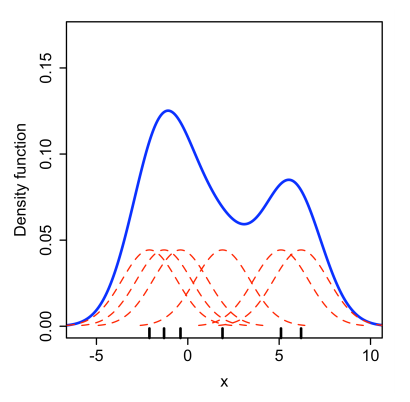

In [9]:
Image(filename='images/kde.png')

As mentioned before, I will be using the Scipy.Stats.Gaussian_kde method to accomplish this task. However, the equation for how KDE actually works can be seen in the image below. 

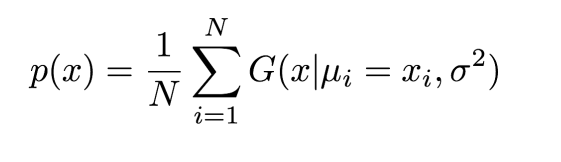

In [10]:
Image(filename='images/kde_equation.png')

In [11]:
def get_kde( spending_data, bins, ss="scott" ):
    return gaussian_kde(spending_data, bw_method=ss).evaluate(xrange(len(bins)))

def get_shopping_data( addresses, amazon_data ):
    data = []
    for address in addresses:
        data.append( amazon_data[amazon_data["Shipping Address Street 1"] == address]["Total Charged"] )
    return data

def get_graph_data( shopping_data, bins, ss=0.5):
    data = []
    for data_point in shopping_data:
        data.append( get_kde(data_point, bins, ss) )
    return data

def plot_graphs( bins, graphs, ss=0.5):
    fig = plt.figure(0)
    ax = fig.add_subplot(111)
    colors = ['blue', 'red', 'green', 'black', 'orange', 'yellow']
    labels = ["me", "my parents", "my sister"]
    handles = []
    
    for index, graph in enumerate(graphs):
        handle, = ax.plot(bins, graph, color=colors[index], alpha=0.5, lw=3, label=("Marginal for %s" % labels[index]))   
        handles.append( handle )
    ax.legend(handles= handles, loc=0)
    plt.xlabel("Expense ($)")
    plt.title("KDE : ss=%.1f" % ss)
    plt.show()

## Analysis

The first thing I do is partition the dataset into the three addresses. Then I create some arbitrary bin size (I found that 500 worked the best for this dataset) and then get the shopping data. 

In [12]:
addresses = ["1169 N 800 W", "27616 DURAZNO", "7995 S ROYAL LN"]

binSize = 500
ss = 0.5

bins = np.linspace(np.min(amazon_data["Total Charged"]), np.max(amazon_data["Total Charged"]), binSize)

shopping_data = get_shopping_data(addresses, amazon_data)

Here you can see I tried a few different bandwidths on the KDE function. While a bandwidth of 0.1 gave me a lot of good partitioning information, it was a little too descriptive. (However, exploring those different partitions might be something fun to do in the future). 

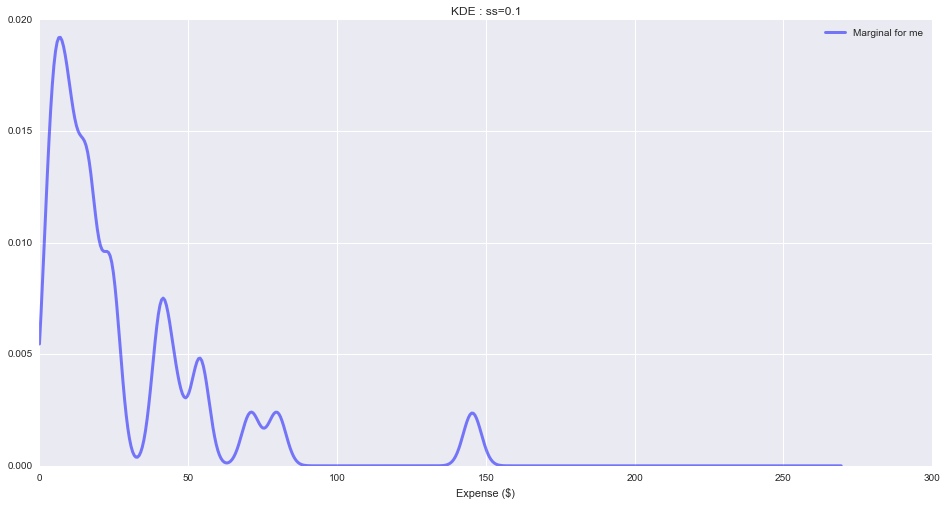

In [13]:
ss = 0.1
graph_data = get_graph_data( shopping_data, bins, ss )
plot_graphs( bins, [graph_data[0]], ss )

A Bandwith of 0.5 gave me some really interesting results. And exactly what I was looking for! I see a normal distribution on the left, and then some strange anomoly on the right side. Bingo! I found a non-normal spending habit of mine that I should explore. 

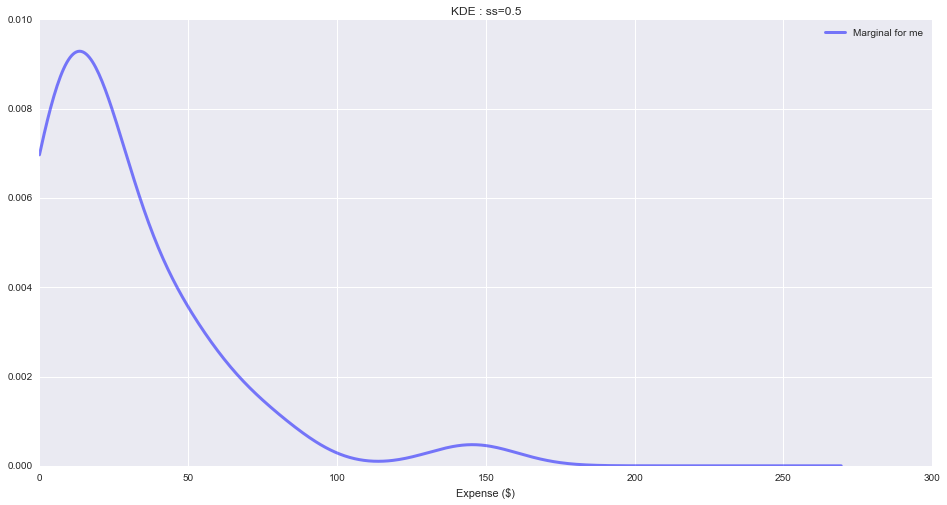

In [14]:
ss = 0.5
graph_data = get_graph_data( shopping_data, bins, ss )
plot_graphs( bins, [graph_data[0]], ss )

Just to be safe, I tried one more bandwidth and saw it was not as useful as 0.5

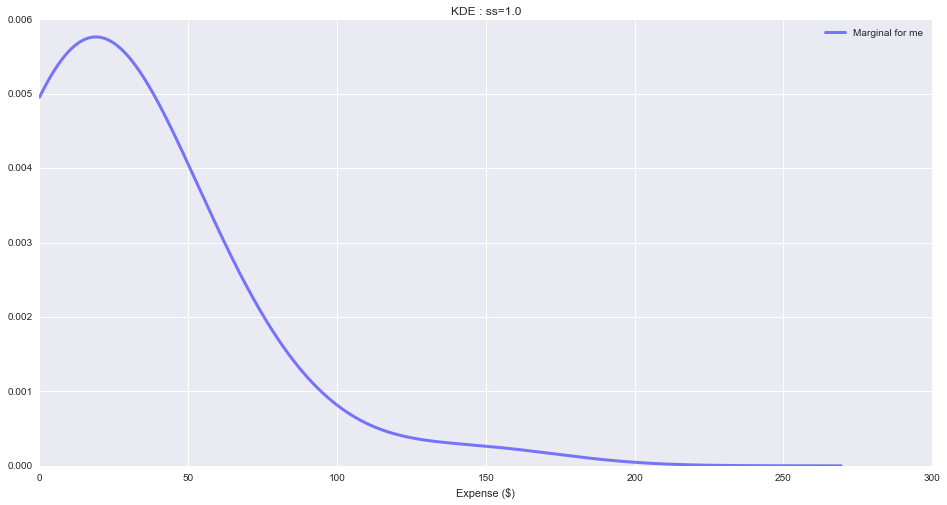

In [15]:
ss = 1.0
graph_data = get_graph_data( shopping_data, bins, ss )
plot_graphs( bins, [graph_data[0]], ss )

Now that I know that there is a strange anomoly of spending between the 120 and 180 dollar range, I can look at those reciepts specifically and ignore the rest of the data for a minute. While that other data is important, I currently just care about this anomoly. I will re-visit that normal data when comparing to my family members. 

In [16]:
print amazon_data[(amazon_data["Shipping Address Street 1"] == "1169 N 800 W") & ( amazon_data["Total Charged"] >= 120) & ( amazon_data["Total Charged"] <= 180)]["Order ID"]

45    105-0491051-2565016
53    107-9512705-6556201
Name: Order ID, dtype: object


Ah yes. I found (and remember) the cause of my weird spending. It was around my birthday when I got really excited about robots and wanted to make my own. I bought 2 orders a few weeks apart, and it definitely was not normal for me to spend that way. Below are the images of my spending; now it makes sense!

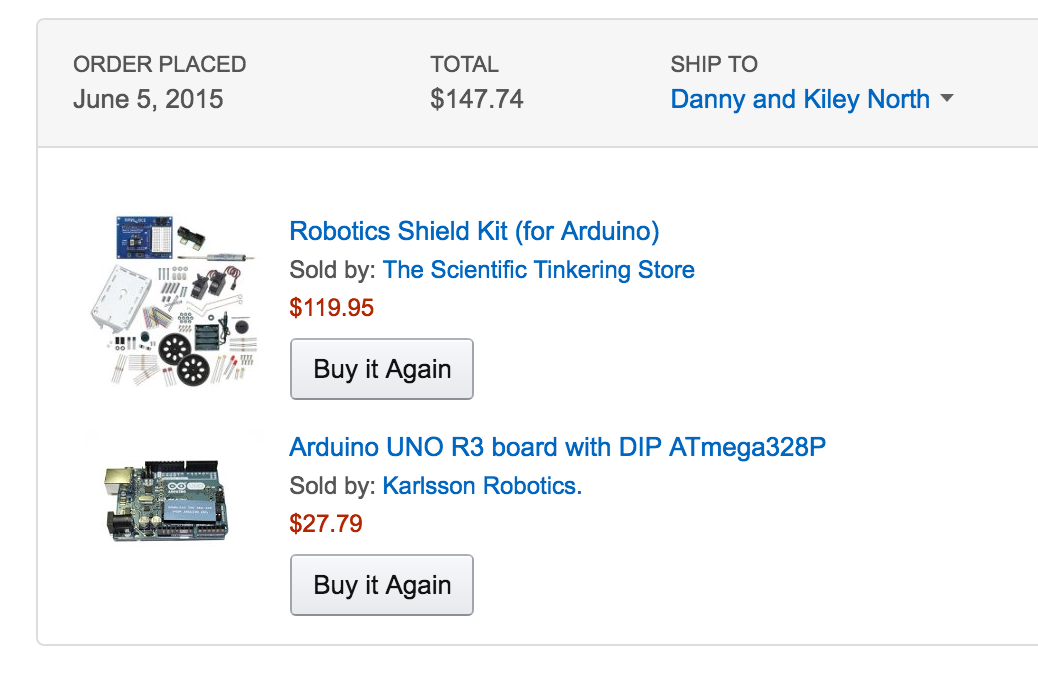

In [17]:
Image(filename='images/amazon1.png')

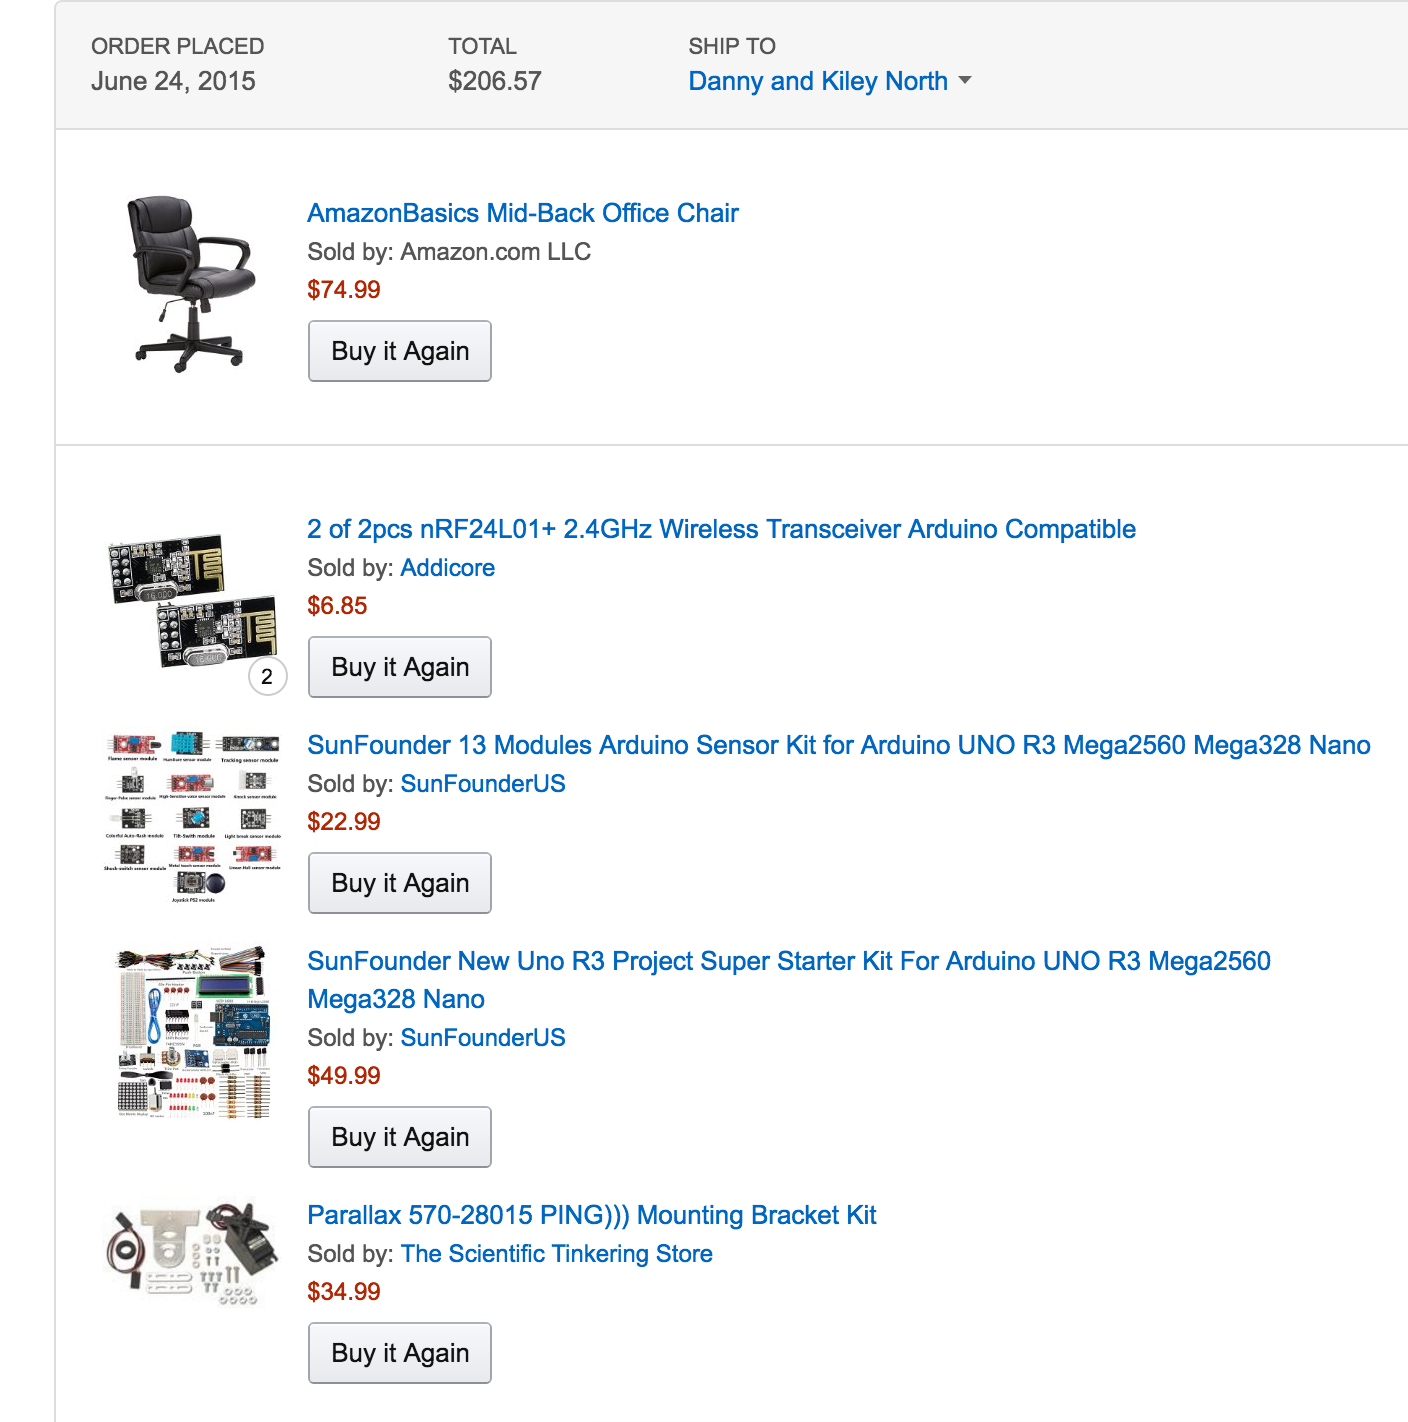

In [18]:
Image(filename='images/amazon2.png')

The final test I want to try is comparing my personal shopping data with the data of my family. The results of this comparison is seen in the graph below, and has contains some interesting information!

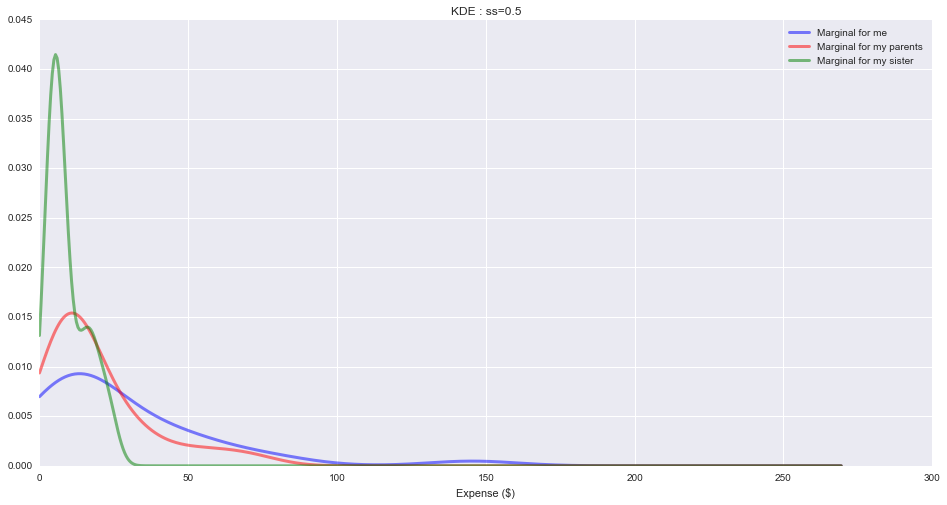

In [20]:
ss = 0.5
graph_data = get_graph_data( shopping_data, bins, ss )
plot_graphs( bins, graph_data, ss )

From this graph we can see a few things clearly. 

1. I was willing to spend more money generally than my parents. And my parents were generally willing to spend more money per order than my sister. Interestingly enough, my sister was NOT willing to spend more than about $30 on any one order. 

2. The average distribution of orders seemed to be between $15 - $25 for all of us. I consider this to be true for most Amazon Prime purchases! So this was a great validation of my initial predictions. 

In conclusion, KDE provided a great platform to perform these tests and see patterns for myself personally and within my family. One potential problem with the reporting that I noticed was that amazon's "Order History" isn't 100% accurate. It seems that it splits orders into multiple groups if they're coming from multiple places. This means that although I ordered something worth $200, because it came from multiple places, the order was counted twice. Once for $75 and another time for the remaining total. I am curious to see what kind of results I could get if the reporting clumped orders together. That might be something for future research.